In [1]:
import galprime as grp

from photutils import morphology
from photutils.isophote import EllipseGeometry, Ellipse
from photutils.aperture import EllipticalAperture

from matplotlib import pyplot as plt
import numpy as np

In [2]:
def estimate_morphology(cutout, mask=None):
    """
    Estimate the morphology of a galaxy.
    """
    try:
        morph = morphology.data_properties(cutout, mask=mask).to_table()
        x0, y0 = morph['xcentroid'][0], morph['ycentroid'][0]
        pa = morph['orientation'][0]
        a, b = morph['semimajor_sigma'][0], morph['semiminor_sigma'][0]
        return EllipseGeometry(x0=x0, y0=y0,  sma=a.value, eps=1 - b/a, pa=np.deg2rad(pa.value))
    except Exception as e:
        print(f"Error: {e}")
        return None


def convert_ellipsegeometry_to_ellipticalaperture(eg):
    b = eg.sma * (1 - eg.eps)
    return EllipticalAperture(positions=(eg.x0, eg.y0), a=eg.sma, b=b.value, theta=eg.pa)

10
10


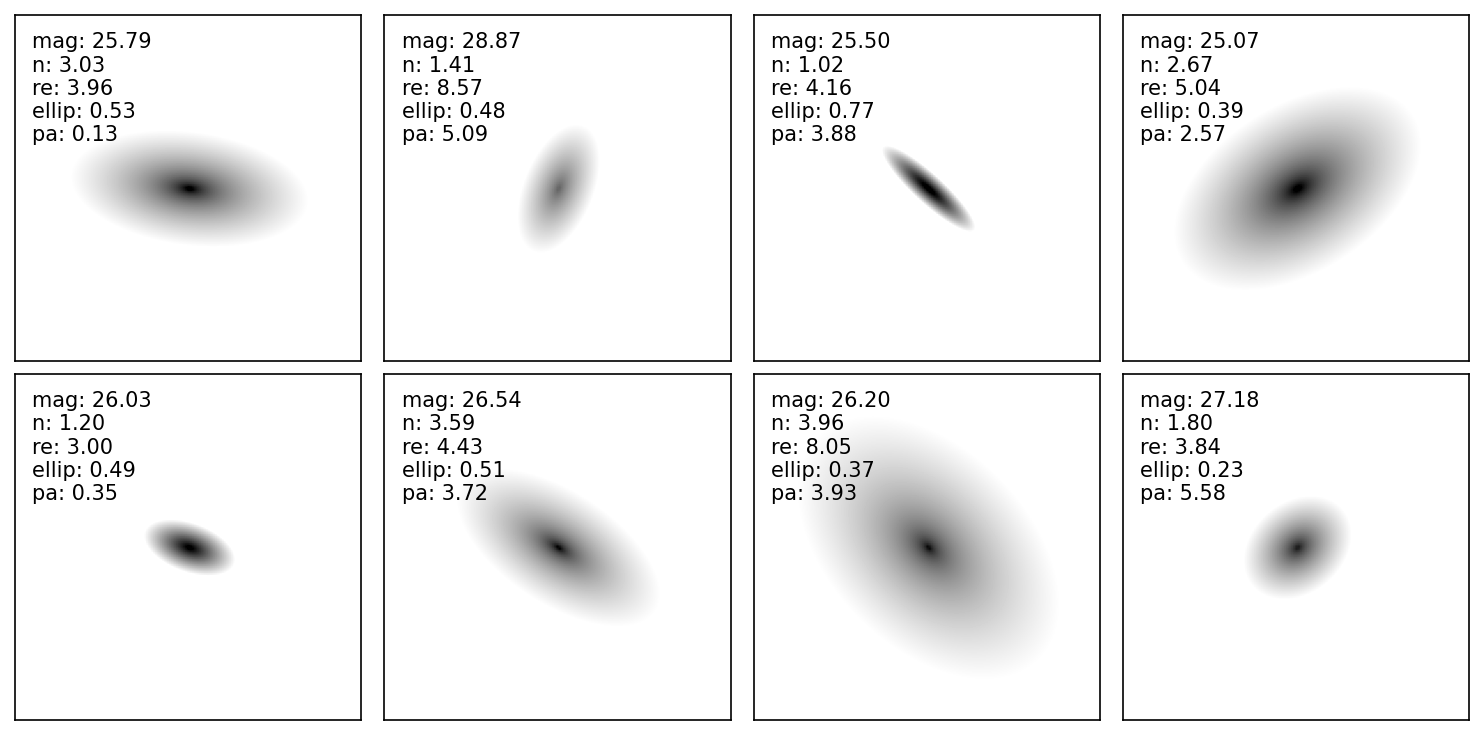

In [12]:
models = grp.gen_sersic_models(10, width=(151, 151))

print(len(models.cutout_data))
models.show_cutouts(method="log", vmin=-5, vmax=-1, ncols=4, model_data=models.cutout_data)




In [25]:

class PoorFitException(Exception):
    pass


def isophote_fitting(data, config):
    fail_count, max_fails = 0, 100
    linear = config.get("EXTRACTION", {}).get("LINEAR", False)
    step = config.get("EXTRACTION", {}).get("STEP", 0.1)
    fix_center = config.get("EXTRACTION", {}).get("FIX_CENTER", False)
    maxit = config.get("EXTRACTION", {}).get("MAXIT", 100)

    cutout_halfwidth = max((data.shape[0] // 2, data.shape[1] // 2))
    maxrit = config.get("EXTRACTION", {}).get("MAXRIT", cutout_halfwidth / 3)

    def attempt_fit(geo):
        flux = Ellipse(data, geo)
        try:
            fitting_list = flux.fit_image(maxit=maxit, maxsma=cutout_halfwidth, step=step, linear=linear,
                                        maxrit=maxrit, fix_center=fix_center)
            if len(fitting_list) > 0:
                return fitting_list
            else:
                raise PoorFitException("Bad fit")
        except Exception as e:
            raise PoorFitException("Bad fit!")
    
    # First try to get an extraction by estimating the morphology
    try:
        geo = estimate_morphology(data)
        print(geo)
        if geo is not None:
            fitting_list = attempt_fit(geo)
            print(fitting_list)
            return fitting_list
    except PoorFitException as e:
        fail_count += 1

    print("Morhpology estimation failed, trying other methods...")

    # If that fails, try a range of possible ellipses
    for sma in np.arange(10, cutout_halfwidth, 10):
        for eps in [0.1, 0.5, 0.9]:
            for pa in np.deg2rad([0, 45, 90, 135]):
                geo = EllipseGeometry(x0=data.shape[1] // 2, y0=data.shape[0] // 2, sma=sma, eps=eps, pa=pa)
        try:
            fitting_list = attempt_fit(geo)
            return fitting_list
        except PoorFitException as e:
            fail_count += 1
        if fail_count > max_fails:
            raise Exception("Too many failed fits!")
    
    return None
            


Morhpology estimation failed, trying other methods...


Morhpology estimation failed, trying other methods...
Morhpology estimation failed, trying other methods...


Morhpology estimation failed, trying other methods...


Morhpology estimation failed, trying other methods...


Morhpology estimation failed, trying other methods...


Morhpology estimation failed, trying other methods...
Morhpology estimation failed, trying other methods...
Morhpology estimation failed, trying other methods...


Morhpology estimation failed, trying other methods...


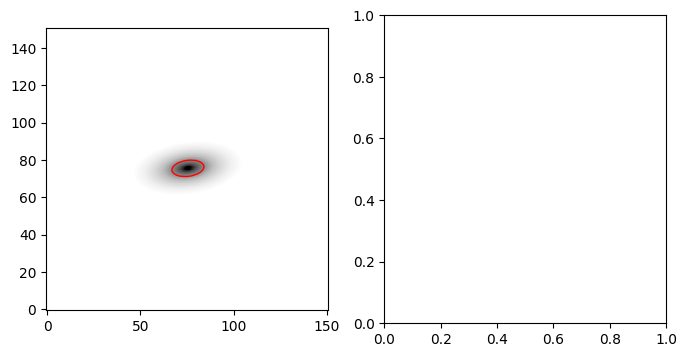

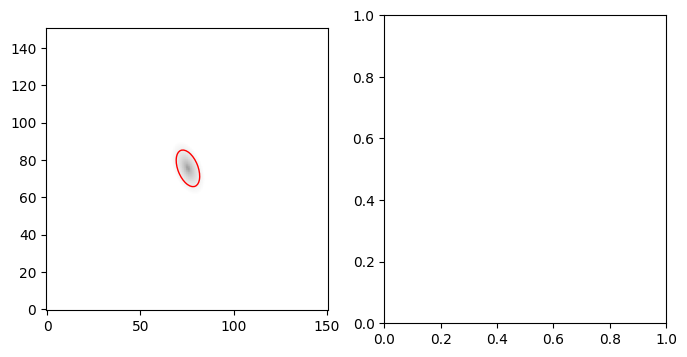

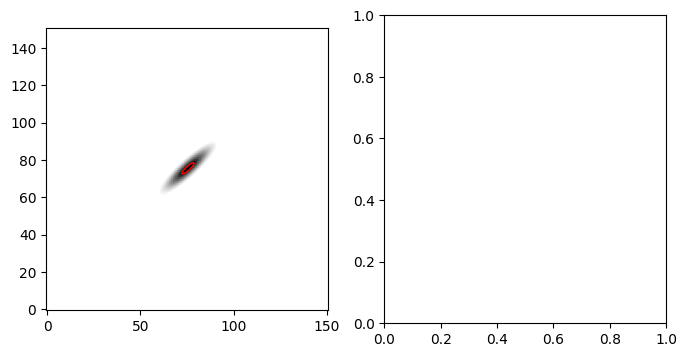

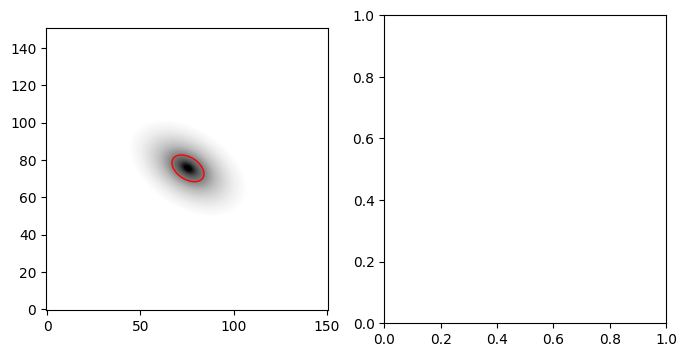

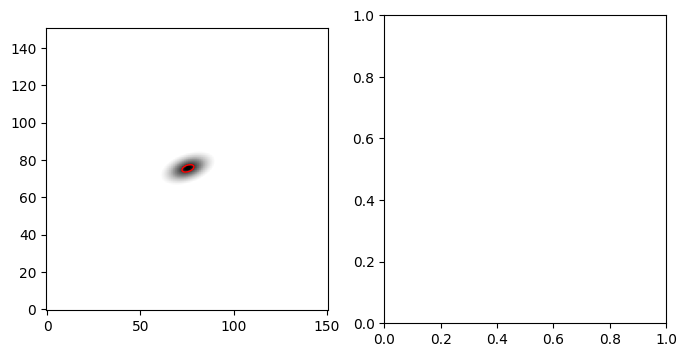

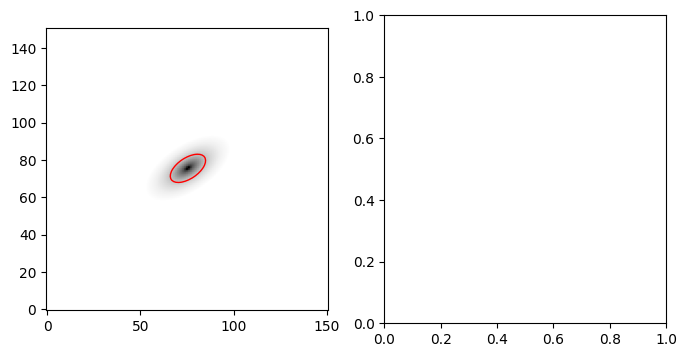

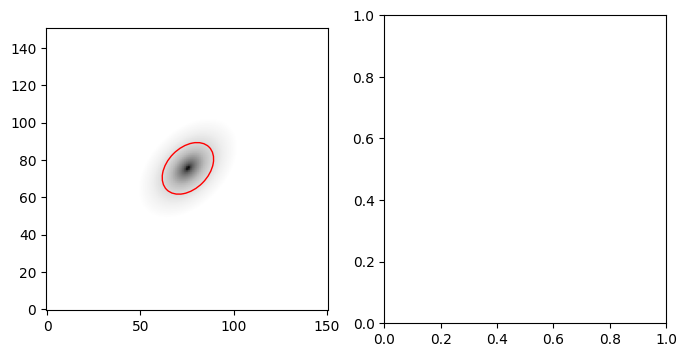

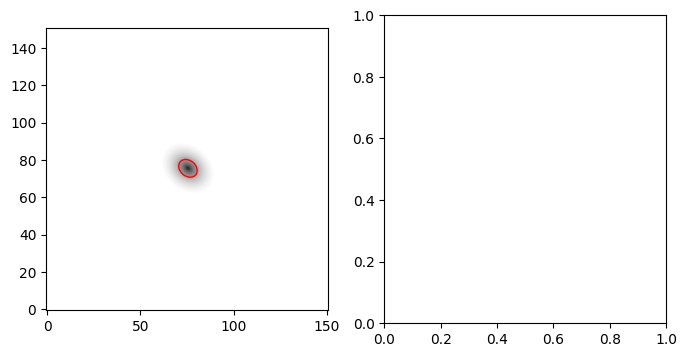

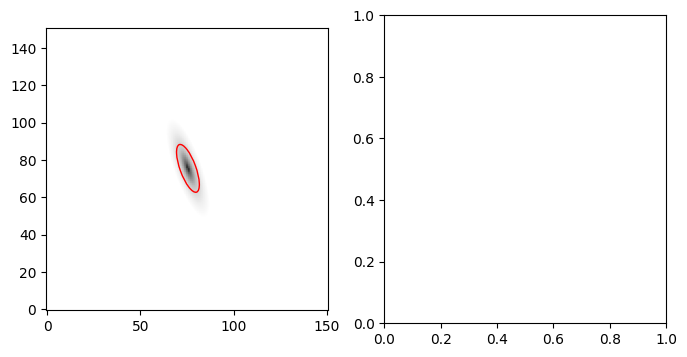

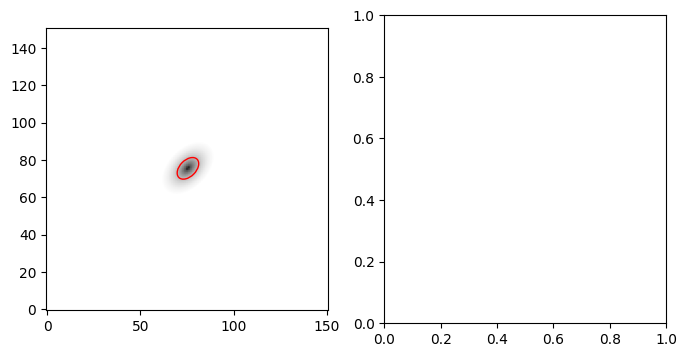

In [26]:
for cutout in models.cutouts:
    morph = estimate_morphology(cutout)
    geo = convert_ellipsegeometry_to_ellipticalaperture(morph)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    ax[0].imshow(np.log10(cutout), cmap='Greys', origin='lower', vmin=-4, vmax=-1)
    geo.plot(ax=ax[0], color='red')

    isolist = isophote_fitting(cutout, grp.default_config())
    